檔名:(您的學號)_hw3.ipynb

In [4]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

一.載入資料集:https://www.kaggle.com/datasets/lara311/flowers-five-classes (10分)

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Subtracts the mean from each value and then divides by the standard deviation.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


In [6]:
data_dir = "/kaggle/input/flowers-five-classes/train"
# Use ImageFolder to point to our full dataset
# Use ImageFolder to point to our full dataset
image_datasets =  datasets.ImageFolder(data_dir, data_transforms)

# Create our dataloaders
dataloaders = torch.utils.data.DataLoader(image_datasets, batch_size=5, shuffle=True, num_workers=4) 

# Get our dataset sizes
dataset_sizes = len(image_datasets)
print(dataset_sizes)

class_names = image_datasets.classes
print(class_names)

2746
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


二.視覺化每個類別的第一張圖和各自的真實標籤(10分)

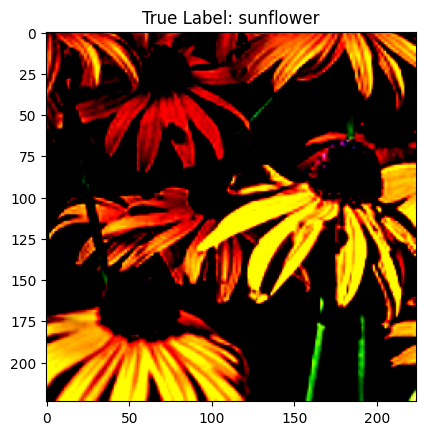

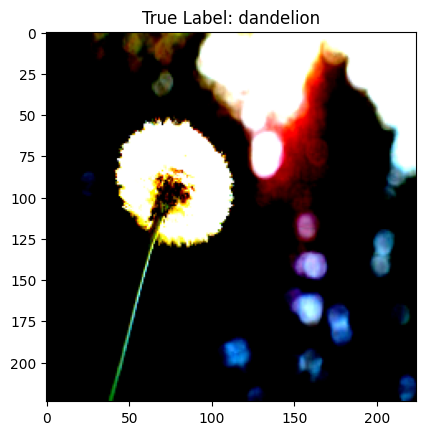

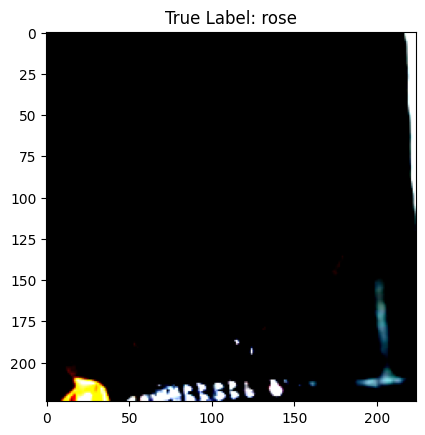

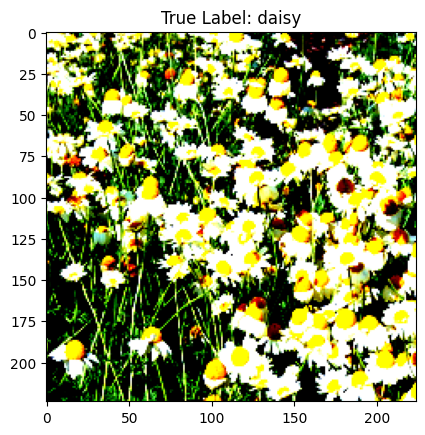

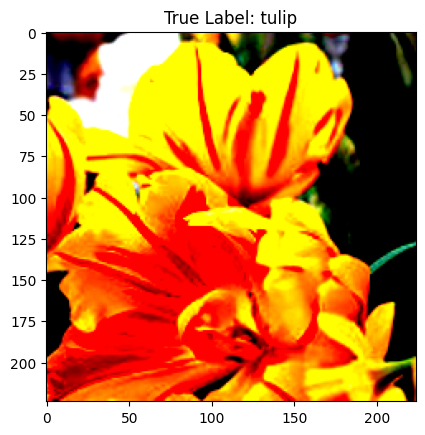

In [7]:
def imshow(img, title=None):
    """显示图像"""
    img = img.numpy().transpose((1, 2, 0))
    img = np.clip(img, 0, 1)  # 将像素值限制在 0-1 之间
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.pause(0.001)  # 适用于交互式环境

# 用于存储每个类别的第一张图片
first_images = {}

# 遍历数据集并获取每个类别的第一张图片
for inputs, labels in dataloaders:
    label_name = class_names[labels[0]]

    # 如果这个类别的第一张图片还没有存储，则存储它
    if label_name not in first_images:
        first_images[label_name] = inputs[0]

    # 如果已经获取到每个类别的第一张图片，则结束循环
    if len(first_images) == len(class_names):
        break

# 可视化每个类别的第一张图片及其真实标签
for label_name, img in first_images.items():
    plt.figure()
    imshow(img, title=f"True Label: {label_name}")
    plt.show()

三.使用resnet18模型推論每種類別的前五張圖片,顯示出圖片、真實標籤和預測標籤(10分)

In [8]:
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)
model.eval()
model.to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 103MB/s] 


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  


Class: daisy


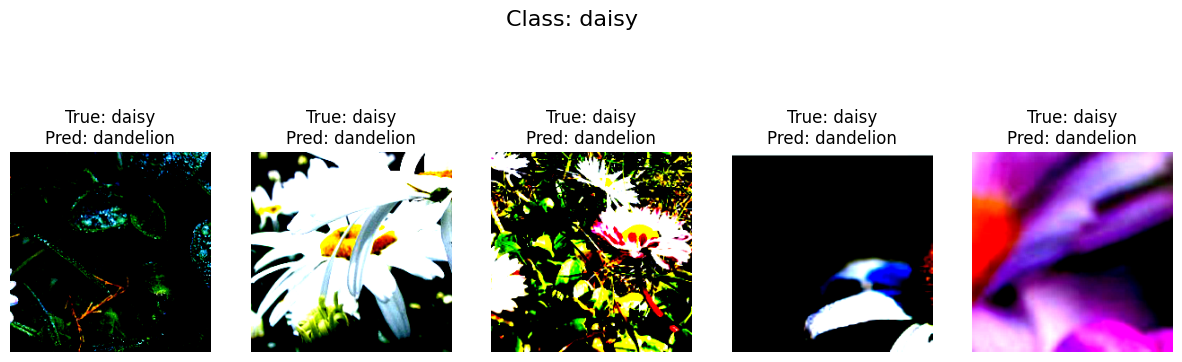


Class: dandelion


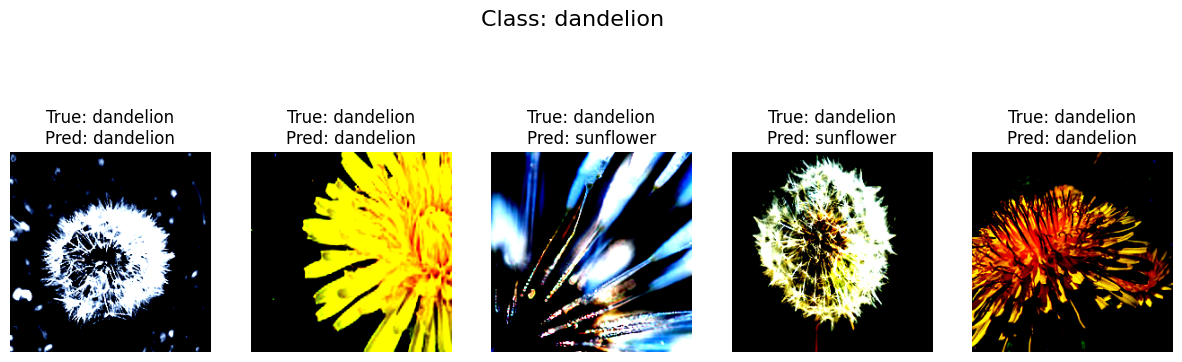


Class: rose


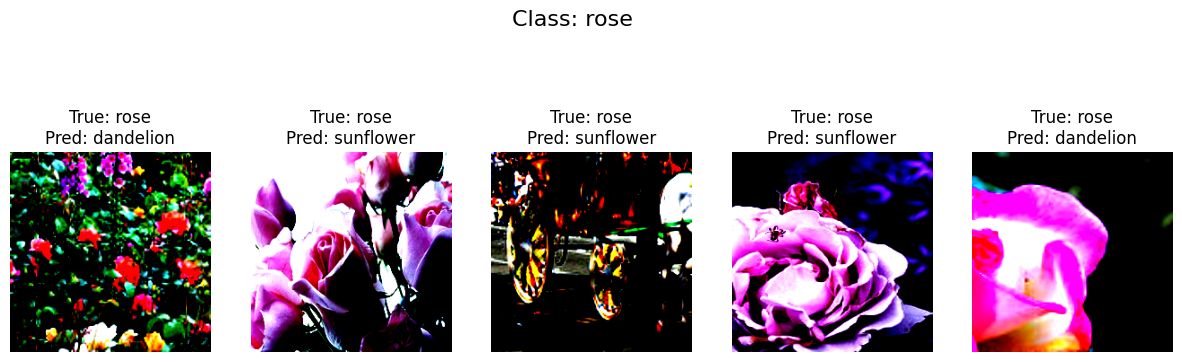


Class: sunflower


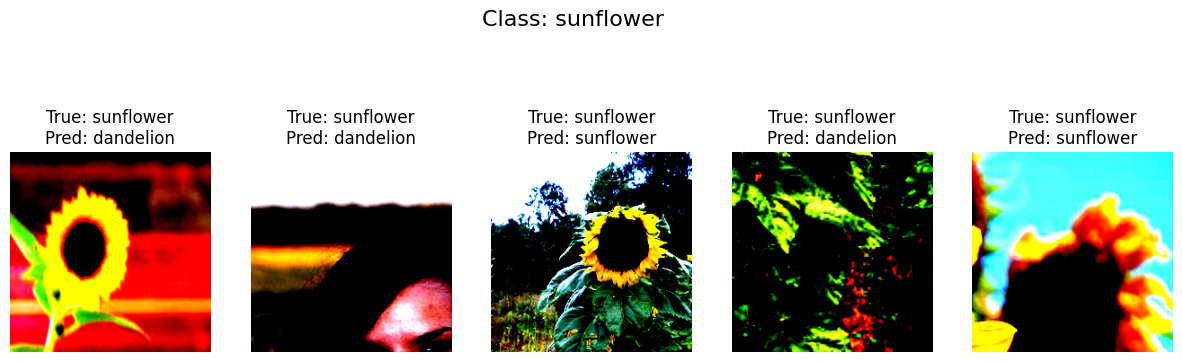


Class: tulip


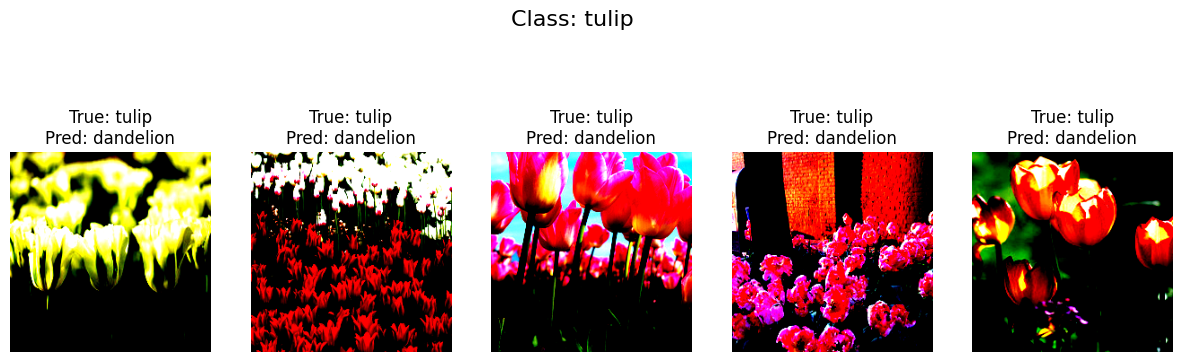

In [9]:
# 用于存储每个类别的前五张图片及其预测
class_images = {class_name: [] for class_name in class_names}

# 推论和显示每个类别的前五张图片
for inputs, labels in dataloaders:
    if all(len(v) >= 5 for v in class_images.values()):
        break  # 每个类别已有5张图片，停止推论

    inputs = inputs.to(device)
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)

    # 获取当前的标签和预测
    true_label = class_names[labels[0]]
    pred_label = class_names[preds[0]]

    # 只在类别少于5张时添加图片
    if len(class_images[true_label]) < 5:
        class_images[true_label].append((inputs[0], true_label, pred_label))

# 横向显示每个类别的前五张图片
for class_name, images in class_images.items():
    print(f"\nClass: {class_name}")
    
    # 创建一个新的图形窗口
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))  # 1 行 5 列的子图
    fig.suptitle(f"Class: {class_name}", fontsize=16)  # 设置类别标题
    
    for i, (img, true_label, pred_label) in enumerate(images):
        ax = axs[i]  # 选择当前的子图
        img = img.cpu().numpy().transpose((1, 2, 0))  # 转置图像为 HWC 格式
        img = np.clip(img, 0, 1)  # 将像素值限制在 0-1 之间
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPred: {pred_label}")  # 设置子图标题
        ax.axis('off')  # 隐藏坐标轴
    
    plt.show()  # 显示图片

四.使用resnet18模型,修改輸出層為5個類別並推論資料集的所有圖片,計算並顯示出Accuracy和Rank 2 Accuracy(10分)

In [10]:

# 定義 Accuracy
def calculate_accuracy(outputs, labels):
    _, preds = torch.max(outputs, 1)
    correct = torch.sum(preds == labels).item()
    return correct

# 定義 Rank-2 Accuracy
def calculate_rank2_accuracy(outputs, labels):
    top2_preds = torch.topk(outputs, 2, dim=1)[1]  
    correct_rank2 = sum([labels[i].item() in top2_preds[i].cpu().numpy() for i in range(len(labels))])
    return correct_rank2

# 計算 Accuracy 和 Rank-2 Accuracy
total_images = 0
correct_top1 = 0
correct_top2 = 0

model.eval()  # 模型評估
with torch.no_grad():
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 推论
        outputs = model(inputs)

        # 计算 top-1 Accuracy
        correct_top1 += calculate_accuracy(outputs, labels)
        
        # 计算 Rank-2 Accuracy
        correct_top2 += calculate_rank2_accuracy(outputs, labels)

        total_images += labels.size(0)

# 計算Accuracy
accuracy = correct_top1 / total_images
rank2_accuracy = correct_top2 / total_images

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Rank-2 Accuracy: {rank2_accuracy * 100:.2f}%')

Accuracy: 22.61%
Rank-2 Accuracy: 42.53%


五.資料預處理且將資料集分割成80% 訓練集, 10% 驗證集, 10% 測試集(10分)

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Subtracts the mean from each value and then divides by the standard deviation.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # resizes the images so the shortest side has a length of 256 pixels.
        # The other side is scaled to maintain the aspect ratio of the image.
        transforms.Resize(256),
        # crops the center of the image so it is a 224 by 224 pixels square image.
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        # resizes the images so the shortest side has a length of 256 pixels.
        # The other side is scaled to maintain the aspect ratio of the image.
        transforms.Resize(256),
        # crops the center of the image so it is a 224 by 224 pixels square image.
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [12]:
dataset_size = len(image_datasets)
train_size = int(0.8 * dataset_size)  # 80% 训练集
val_size = int(0.1 * dataset_size)    # 10% 验证集
test_size = dataset_size - train_size - val_size  # 剩下的为测试集

# 訓練集、驗證集、測試集
train_dataset, val_dataset, test_dataset = random_split(image_datasets, [train_size, val_size, test_size])

# Dataloader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Training set size: {train_size}")
print(f"Validation set size: {val_size}")
print(f"Test set size: {test_size}")

Training set size: 2196
Validation set size: 274
Test set size: 276


六:微調resnet18模型,修改輸出層為5個類別並設置learning rate scheduler和Checkpoint -> saving the best model,請顯示出訓練過程,包含每個epoh的Train Accuracy和validation accuracy,以及Checkpoint的狀況(25分)

In [13]:
# 訓練
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # 每個epoch 都進行訓練與驗證
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 訓練
            else:
                model.eval()   # 驗證

            running_loss = 0.0
            running_corrects = 0

            # 資料批次訓練 & 驗證
            dataloader = train_loader if phase == 'train' else val_loader
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # 僅在訓練時反向傳播與優化
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 計算loss與 accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # 更新學習率
            if phase == 'train':
                scheduler.step()

            # 計算loss與 accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 複製模型
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'New best model found at epoch {epoch + 1}, saving checkpoint...')

    # 加载最佳模型权重
    model.load_state_dict(best_model_wts)
    return model


In [14]:
# 定義損失函數&優化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# 學習率調整
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
best_model = train_model(model, criterion, optimizer, scheduler, num_epochs=15)

# 保存最优模型
torch.save(best_model.state_dict(), 'best_model_resnet18.pth')


Epoch 1/15
----------
train Loss: 0.8793 Acc: 0.6767
val Loss: 0.4453 Acc: 0.8504
New best model found at epoch 1, saving checkpoint...
Epoch 2/15
----------
train Loss: 0.3973 Acc: 0.8675
val Loss: 0.3998 Acc: 0.8504
Epoch 3/15
----------
train Loss: 0.3277 Acc: 0.8871
val Loss: 0.3503 Acc: 0.8796
New best model found at epoch 3, saving checkpoint...
Epoch 4/15
----------
train Loss: 0.2956 Acc: 0.8939
val Loss: 0.3321 Acc: 0.8869
New best model found at epoch 4, saving checkpoint...
Epoch 5/15
----------
train Loss: 0.2459 Acc: 0.9194
val Loss: 0.2997 Acc: 0.9015
New best model found at epoch 5, saving checkpoint...
Epoch 6/15
----------
train Loss: 0.2219 Acc: 0.9226
val Loss: 0.2735 Acc: 0.9088
New best model found at epoch 6, saving checkpoint...
Epoch 7/15
----------
train Loss: 0.1835 Acc: 0.9326
val Loss: 0.4360 Acc: 0.8759
Epoch 8/15
----------
train Loss: 0.1782 Acc: 0.9413
val Loss: 0.2954 Acc: 0.8905
Epoch 9/15
----------
train Loss: 0.1657 Acc: 0.9458
val Loss: 0.2932 Acc:

七.顯示出Accuracy和Rank-2 Accuracy(10分)

In [15]:
# 計算 Accuracy 和 Rank-2 Accuracy
total_images = 0
correct_top1 = 0
correct_top2 = 0

best_model.eval()  # 模型評估
with torch.no_grad():
    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 推论
        outputs = best_model(inputs)

        # 计算 top-1 Accuracy
        correct_top1 += calculate_accuracy(outputs, labels)
        
        # 计算 Rank-2 Accuracy
        correct_top2 += calculate_rank2_accuracy(outputs, labels)

        total_images += labels.size(0)

# 計算Accuracy
accuracy = correct_top1 / total_images
rank2_accuracy = correct_top2 / total_images

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Rank-2 Accuracy: {rank2_accuracy * 100:.2f}%')

Accuracy: 94.90%
Rank-2 Accuracy: 98.43%


八.使用微調完的resnet18模型推論測試集每種類別的前五張圖片,顯示出圖片、真實標籤和預測標籤(15分)

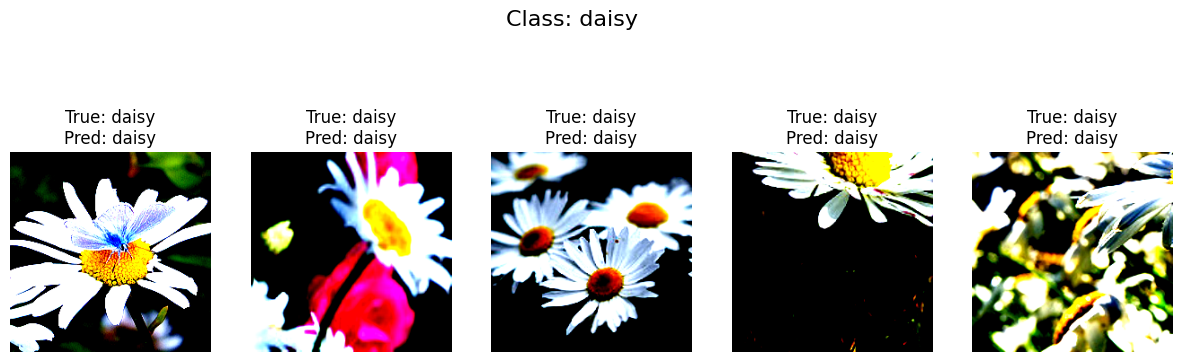

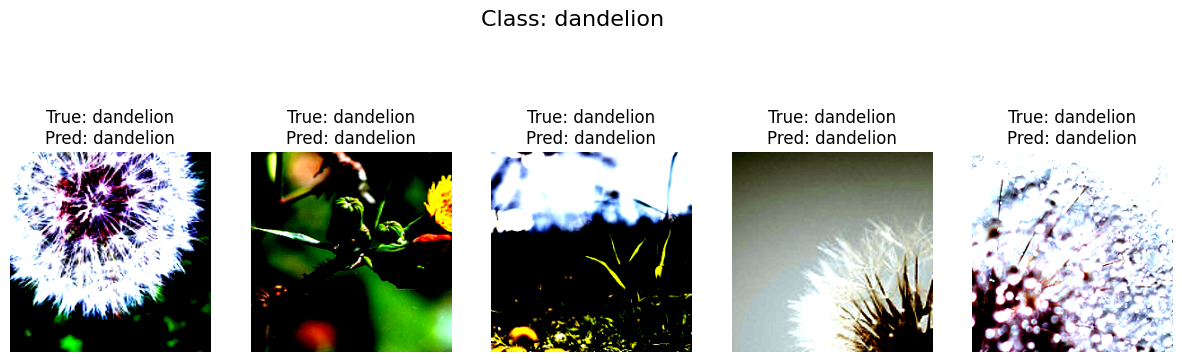

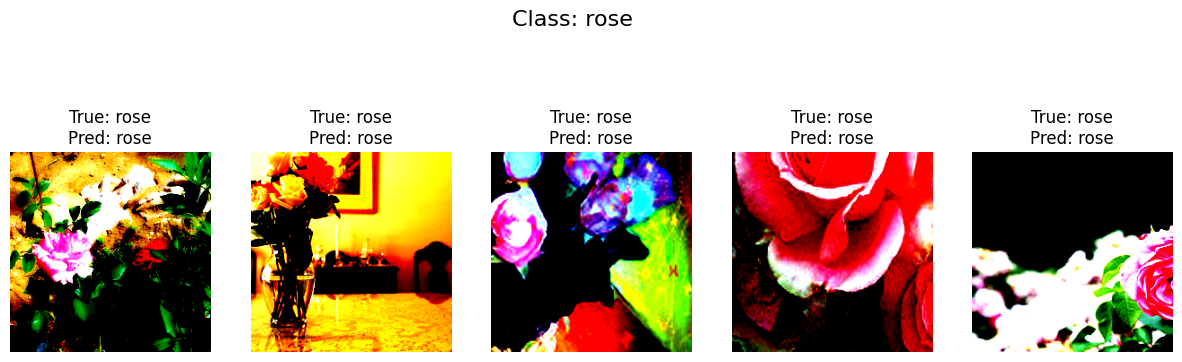

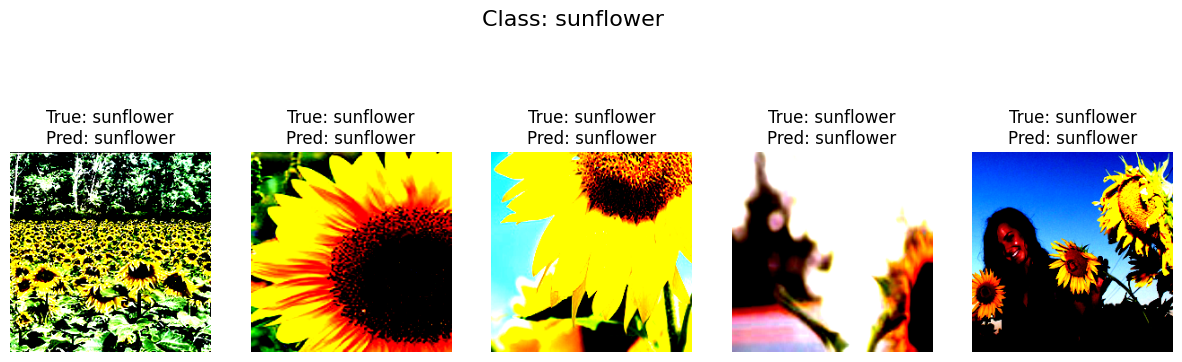

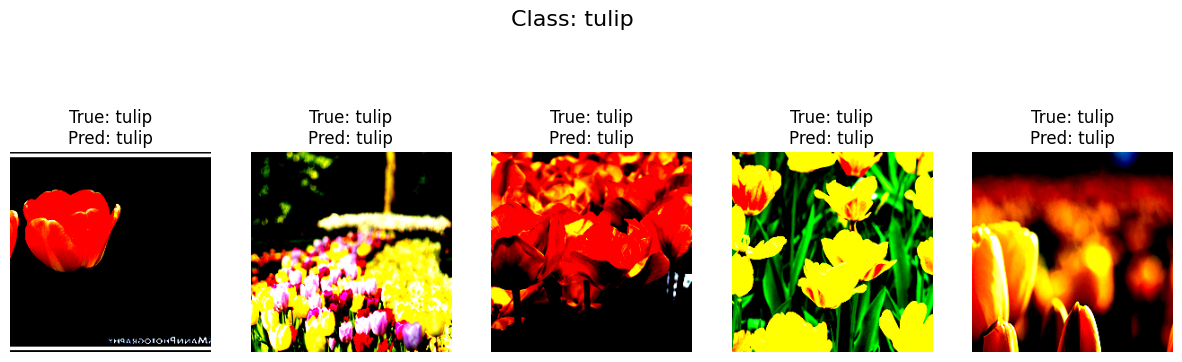

In [17]:

# 顯示圖片的輔助函數
def imshow(inp, title=None):
    """顯示 Tensor 圖片"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])  # 歸一化的均值
    std = np.array([0.229, 0.224, 0.225])   # 歸一化的標準差
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, fontsize=10)
    plt.axis('off')  # 隱藏坐標軸

# 將模型設置為評估模式
best_model.eval()

# 為每個類別儲存前五張圖片
classwise_images = {i: [] for i in range(5)}  # 假設有5個類別
classwise_preds = {i: [] for i in range(5)}   # 儲存前五張圖片的預測標籤
classwise_labels = {i: [] for i in range(5)}  # 儲存前五張圖片的真實標籤

# 遍歷測試集數據
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 獲取模型的預測
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # 遍歷 batch 中的每張圖片
        for img, label, pred in zip(inputs.cpu(), labels.cpu(), preds.cpu()):
            if len(classwise_images[label.item()]) < 5:
                classwise_images[label.item()].append(img)
                classwise_preds[label.item()].append(pred.item())
                classwise_labels[label.item()].append(label.item())

        # 當所有類別都有5張圖片時，停止
        if all(len(classwise_images[i]) >= 5 for i in range(5)):
            break
# print(classwise_images)
# 横向显示每个类别的前五张图片
for class_id in range(5):  # 假設有5個類別
    
    # 创建一个新的图形窗口
    fig, axs = plt.subplots(1, 5, figsize=(15, 5))  # 1 行 5 列的子图
    fig.suptitle(f"Class: {class_names[class_id]}", fontsize=16)  # 设置类别标题
    
    for i, (img) in enumerate(classwise_images[class_id]):
        ax = axs[i]  # 选择当前的子图
        img = img.cpu().numpy().transpose((1, 2, 0))  # 转置图像为 HWC 格式
        img = np.clip(img, 0, 1)  # 将像素值限制在 0-1 之间
        ax.imshow(img)
        ax.set_title(f"True: {class_names[classwise_labels[class_id][i]]}\nPred: {class_names[classwise_preds[class_id][i]]}")  # 设置子图标题
        ax.axis('off')  # 隐藏坐标轴
    
    plt.show()  # 显示图片